In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from loss import MultiResSpecLoss
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import ScaleInvariantSignalDistortionRatio
import torchaudio

from model import Unet_model
from Modules import STFT
from data import generate_mixture

import warnings
warnings.filterwarnings("ignore")


In [2]:
class my_dataset(Dataset):
    def __init__(self, root, url, sec=None, snr_noise=10):
        
        self.data = torchaudio.datasets.LIBRISPEECH(root=root, download=False, url=url)
        
        self.snr_noise = snr_noise
        if sec:
            self.sec = sec*16000
        else:
             self.sec = sec
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        target = self.data[idx][0]
        
        #target = F.pad(target, (0, mic_array.shape[-1] - target.shape[-1]))
        
        if self.sec:
            return target[:,:self.sec], generate_mixture(target,  torch.rand(1, target.shape[-1]), 10)[:,:self.sec]
        else:
            return  target, generate_mixture(target,  torch.rand(1, target.shape[-1]), self.snr_noise)

In [3]:
data_train = my_dataset(root='.\data',  url = 'train-clean-100', sec=1, snr_noise=0)
data_valid = my_dataset(root='.\data1',  url = 'test-clean', sec=1, snr_noise=0)

train_dataloader = DataLoader(data_train, batch_size=256, shuffle=True, drop_last=True)
test_dataloader = DataLoader(data_valid, batch_size=256, shuffle=False, drop_last=False)

In [4]:
# init
torch.manual_seed(1)

fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

unet_mask = Unet_model()
si = ScaleInvariantSignalDistortionRatio()
losses_epoch_train = []
metrics_epoch_train = []
losses_epoch_valid = []
metrics_epoch_valid = []
lrs = []
epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = MultiResSpecLoss(n_ffts=[1024, 400],f_complex=100, factor=100, gamma=0.3).to(device)

optim = torch.optim.AdamW(unet_mask.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=50
        )
unet_mask.to(device);

In [5]:
import logging
import logging.config

LOGGER = logging.getLogger("Train")
LOGGER.setLevel(logging.DEBUG)
file_handler = logging.FileHandler("denoise_libre.log")
file_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter("%(message)s")
file_handler.setFormatter(formatter)
LOGGER.addHandler(file_handler)
LOGGER.info(f"epchs, train_loss, train_metric, valid_loss, valid_metric")

In [6]:
LOGGER_step = logging.getLogger("Train_step")
LOGGER_step.setLevel(logging.DEBUG)
file_handler_step = logging.FileHandler("denoise_libre_step.log")
file_handler_step.setLevel(logging.DEBUG)
formatter_step = logging.Formatter("%(message)s")
file_handler_step.setFormatter(formatter_step)
LOGGER_step.addHandler(file_handler_step)
LOGGER_step.info(f"step, train_loss_step, train_metric_step")

In [7]:
import torch as th

def pipline(model, sample):
    spec_sample = stft.stft(sample)
    
    B, C, F, T = spec_sample.shape
    mag = spec_sample.abs()
    phase = spec_sample.angle()
    
    mask = model(torch.log(mag+1e-5))

    mag_predict = mag * mask
    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)
    
    z = th.complex(real, imag)
    wave_predict = stft.istft(z, sample.shape[-1]) #.view(B, sample.shape[-1])
    return wave_predict

In [ ]:
mn = -100

for epoch in tqdm(range(epochs)):
    
    losses_train = []
    metrics_train = []
    unet_mask.train()
    step = 0
    for batch_idx, batch in enumerate(train_dataloader):
        optim.zero_grad()
        
        target, noise = batch
        #ref = find_ref_chennel(mic)
        predictions = pipline(unet_mask, noise.to(device))
        loss = criterion(predictions, target.to(device)) + F.mse_loss(predictions, target.to(device))
        
        loss.backward()
        optim.step()
        metrics_train.append(si(predictions.detach().cpu(), target.cpu()))
        losses_train.append(loss.item())
        step += 1
        
        LOGGER_step.info(f"{step},{losses_train[-1]},{metrics_train[-1]}")

        #print("Epoch [{}/{}], train_loss: {:.4f}, train_metric: {:.4f}".format(batch_idx+1, epochs, losses_train[-1], metrics_train[-1]))

    lrs.append(scheduler.get_lr()[0])
    scheduler.step()
    losses_epoch_train.append(sum(losses_train)/len(losses_train))
    metrics_epoch_train.append(sum(metrics_train)/len(metrics_train))
    
    
    losses_val = []
    metrics_val = []
    unet_mask.eval()
    for batch_idx, batch in enumerate(test_dataloader):
        target, noise = batch
        #ref = find_ref_chennel(mic)
        predictions = pipline(unet_mask, noise.to(device))
        loss = criterion(predictions, target.to(device)) + F.mse_loss(predictions, target.to(device))
        metrics_val.append(si(predictions.detach().cpu(), target.cpu()))
        losses_val.append(loss.item())
    

    losses_epoch_valid.append(sum(losses_val)/len(losses_val))
    metrics_epoch_valid.append(sum(metrics_val)/len(metrics_val))
    
    LOGGER.info(f"{epoch+1},{losses_epoch_train[-1]},{metrics_epoch_train[-1]},{losses_epoch_valid[-1]},{metrics_epoch_valid[-1]}")
    if mn < metrics_epoch_valid[-1]:
        mn = metrics_epoch_valid[-1]
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': unet_mask.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses_epoch_train[-1],
            }, f'checkpoint_denoise.pt')

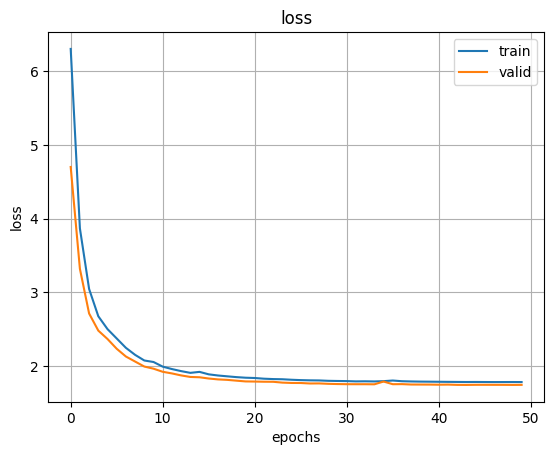

In [19]:
from matplotlib import pyplot as plt
plt.title('loss')
plt.plot(losses_epoch_train, label='train')
plt.plot(losses_epoch_valid, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

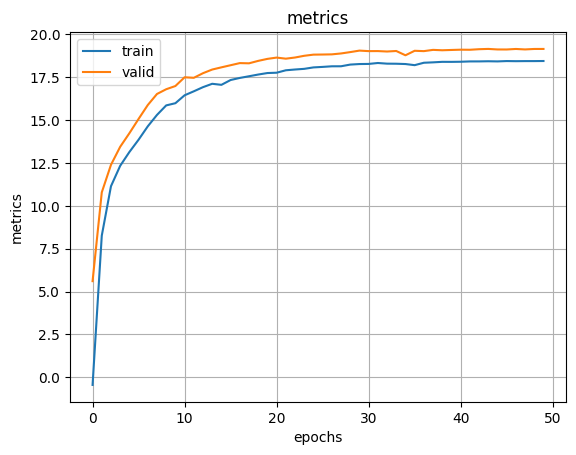

In [20]:
plt.title('metrics')
plt.plot(metrics_epoch_train, label='train')
plt.plot(metrics_epoch_valid, label='valid')
plt.grid()
plt.legend()
plt.xlabel('epochs')
plt.ylabel('metrics')
plt.show()

In [21]:
from IPython.display import Audio
Audio(target[0][0], rate=16000)

In [22]:
Audio(noise[0][0], rate=16000)

In [25]:
predictions = pipline(unet_mask, noise.to(device))

In [26]:
Audio(predictions[0].detach().cpu(), rate=16000)